In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.random.set_seed(32)
print(tf.__version__)

Mounted at /content/drive
2.6.0


In [2]:
!unzip -q '/content/drive/MyDrive/train_small.zip' -d data
!unzip -q '/content/drive/MyDrive/test_small.zip' -d data

In [3]:
sample_submission = pd.read_csv(
    "/content/drive/MyDrive/sample_submission.csv", index_col=0
)
sample_submission.head()

,Pteraster_capensis,Porifera,Astropecten_irregularis_pontoporeus,Terebratulina_sp_,Neolithodes_asperrimus,Munida_benguela,Cypraeovula_iutsui,Kaloplocamus_ramosus,Actinoscyphia_plebeia,Echinus_gilchristi,Synallactes_viridilimus,Eleutherobia_variable,Neopilumnoplax_heterochir,Pleurobranchaea_bubala,Pagurus_cuanensis,Parapagurus_bouvieri,Inachidae,Pseudarchaster_tessellatus,Pasiphaea_sp._1,Suberites_dandelenae,Comitas_saldanhae,Poraniopsis_echinaster,Pterygosquilla_capensis,Holothuroidea,Exodromidia_spinosa,Aristeus_varidens,Philinopsis_capensis,Vitjazmaia_latidactyla,Perissasterias_polyacantha,Ascidiacea,Toraster_tuberculatus,Nudibranchia,Mediaster_bairdi_capensis,Limopsis_chuni,Comitas_stolida,Psilaster_acuminatus,Lithodes_ferox,Hermit_crab,Solenocera_africana,Cephalodiscus_gilchristi,...,Ophiura_costata_costata,Pelagia_noctiluca,Sclerasterias_spp,Stylasteridae,Fusivoluta_pyrrhostoma,Actinoptilum_molle,Pseudarchaster_brachyactis,Nassarius speciosus,Chondraster_elattosis,Ophiothrix_aristulata,Aphelodoris_sp_,Fusinus_africanae,Scaphander_punctostriatus,Polychaete_tubes_(only),Polychaete_worms,Polyechinus_agulhensis,Chrysaora_spp,Projasus_parkeri,Lamellaria_Coriocella_spp,Hippasteria_phrygiana,Mursia_cristiata,Prawns,Nassarius_vinctus,Marthasterias_africana,Goneplax_clevai,Alcyonacea,Athleta_lutosa,Pseudodromia_spp_,Rochinia_hertwigi,Africolaria_rutila,Neptuneopsis_gilchristi,Pseudodromia_rotunda,Pecten_sulcicostatus,Plesionika_martia,Rossella_antarctica,Philine_aperta,Mycale_anisochela,Henricia_abyssalis,Triviella_spp_,Cheilostomatida
FILE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FNDG3L9.jpeg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0RASRVM.jpeg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
JMXLWAX.jpeg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
CV8FWT2.jpeg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
V34APYI.jpeg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
IMG_HEIGHT=224
IMG_WIDTH=224
BATCH_SIZE=32

training_dataset = image_dataset_from_directory(
    'data/train_small', image_size=(IMG_HEIGHT, IMG_WIDTH), label_mode="categorical",
    seed=2,  validation_split=0.2, subset="training", batch_size=BATCH_SIZE,
    class_names=sample_submission.columns.to_list()
)
validation_dataset = image_dataset_from_directory(
    'data/train_small', image_size=(IMG_HEIGHT, IMG_WIDTH), label_mode="categorical",
    seed=2, validation_split=0.2, subset="validation", batch_size=BATCH_SIZE,
    class_names=sample_submission.columns.to_list()
)
test_dataset = image_dataset_from_directory(
    'data/test_small', image_size=(IMG_HEIGHT, IMG_WIDTH), shuffle=False,
    labels=None, batch_size=BATCH_SIZE
)

Found 3111 files belonging to 137 classes.
Using 2489 files for training.
Found 3111 files belonging to 137 classes.
Using 622 files for validation.
Found 1434 files belonging to 1 classes.


In [5]:
pretrained_featurizer = hub.KerasLayer(
    "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
    trainable=True
)

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3]),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal", seed=8),
    layers.RandomWidth(0.1, seed=8),
    layers.RandomRotation(0.1, seed=8),
    pretrained_featurizer,
    layers.Dense(512),
    layers.Dense(137, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-4),
    loss="categorical_crossentropy",
    metrics="accuracy"
)

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.0001, patience=3, restore_best_weights=True
)

history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
78/78 [==============================] - 89s 588ms/step - loss: 3.4034 - accuracy: 0.3078 - val_loss: 1.9906 - val_accuracy: 0.5482
Epoch 2/50
78/78 [==============================] - 33s 417ms/step - loss: 1.1966 - accuracy: 0.7111 - val_loss: 0.9477 - val_accuracy: 0.7588
Epoch 3/50
78/78 [==============================] - 33s 412ms/step - loss: 0.5560 - accuracy: 0.8610 - val_loss: 0.7061 - val_accuracy: 0.8328
Epoch 4/50
78/78 [==============================] - 32s 405ms/step - loss: 0.3099 - accuracy: 0.9297 - val_loss: 0.5686 - val_accuracy: 0.8505
Epoch 5/50
78/78 [==============================] - 32s 404ms/step - loss: 0.1930 - accuracy: 0.9538 - val_loss: 0.4851 - val_accuracy: 0.8842
Epoch 6/50
78/78 [==============================] - 32s 408ms/step - loss: 0.1456 - accuracy: 0.9654 - val_loss: 0.5404 - val_accuracy: 0.8585
Epoch 7/50
78/78 [==============================] - 32s 412ms/step - loss: 0.1062 - accuracy: 0.9767 - val_loss: 0.4545 - val_accuracy: 0.8875

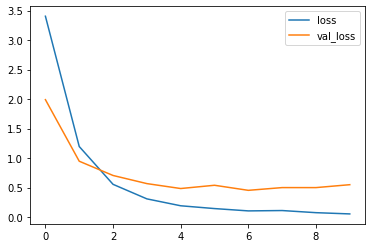

In [7]:
pd.DataFrame(history.history).filter(like="loss").plot()

In [8]:
preds = model.predict(test_dataset)

submission = pd.DataFrame(
    preds, columns=training_dataset.class_names, index=test_dataset.file_paths
)
submission.index = submission.index.str.lstrip("data/test_small/")
submission.head()

,Pteraster_capensis,Porifera,Astropecten_irregularis_pontoporeus,Terebratulina_sp_,Neolithodes_asperrimus,Munida_benguela,Cypraeovula_iutsui,Kaloplocamus_ramosus,Actinoscyphia_plebeia,Echinus_gilchristi,Synallactes_viridilimus,Eleutherobia_variable,Neopilumnoplax_heterochir,Pleurobranchaea_bubala,Pagurus_cuanensis,Parapagurus_bouvieri,Inachidae,Pseudarchaster_tessellatus,Pasiphaea_sp._1,Suberites_dandelenae,Comitas_saldanhae,Poraniopsis_echinaster,Pterygosquilla_capensis,Holothuroidea,Exodromidia_spinosa,Aristeus_varidens,Philinopsis_capensis,Vitjazmaia_latidactyla,Perissasterias_polyacantha,Ascidiacea,Toraster_tuberculatus,Nudibranchia,Mediaster_bairdi_capensis,Limopsis_chuni,Comitas_stolida,Psilaster_acuminatus,Lithodes_ferox,Hermit_crab,Solenocera_africana,Cephalodiscus_gilchristi,...,Ophiura_costata_costata,Pelagia_noctiluca,Sclerasterias_spp,Stylasteridae,Fusivoluta_pyrrhostoma,Actinoptilum_molle,Pseudarchaster_brachyactis,Nassarius speciosus,Chondraster_elattosis,Ophiothrix_aristulata,Aphelodoris_sp_,Fusinus_africanae,Scaphander_punctostriatus,Polychaete_tubes_(only),Polychaete_worms,Polyechinus_agulhensis,Chrysaora_spp,Projasus_parkeri,Lamellaria_Coriocella_spp,Hippasteria_phrygiana,Mursia_cristiata,Prawns,Nassarius_vinctus,Marthasterias_africana,Goneplax_clevai,Alcyonacea,Athleta_lutosa,Pseudodromia_spp_,Rochinia_hertwigi,Africolaria_rutila,Neptuneopsis_gilchristi,Pseudodromia_rotunda,Pecten_sulcicostatus,Plesionika_martia,Rossella_antarctica,Philine_aperta,Mycale_anisochela,Henricia_abyssalis,Triviella_spp_,Cheilostomatida
00G9CO1.jpeg,3.100461e-05,0.000003,1.084680e-04,0.000190,3.423921e-06,8.400642e-05,7.001477e-04,5.777521e-05,1.668342e-05,1.592150e-04,4.436353e-05,6.503590e-05,8.352965e-05,4.259984e-05,2.622783e-05,1.087642e-04,1.702793e-04,3.848309e-06,6.970948e-05,1.923218e-05,1.419798e-04,1.407674e-05,1.974651e-04,1.606155e-03,1.228679e-04,2.055842e-04,1.294234e-05,1.390814e-05,1.520263e-04,5.484543e-05,1.646385e-05,1.407674e-05,3.945605e-05,4.955952e-04,2.627615e-05,1.711116e-04,3.519351e-05,0.000671,3.382656e-04,3.382752e-05,...,3.911489e-05,1.361001e-04,1.465008e-04,6.973139e-06,1.395551e-04,5.575573e-05,4.016049e-05,9.477334e-04,3.050391e-04,4.290907e-05,0.000029,1.500226e-04,2.124551e-03,4.391914e-06,1.067311e-04,6.366538e-05,5.924359e-05,1.941196e-05,3.384145e-04,2.005974e-05,4.439208e-04,2.226694e-05,1.809481e-03,1.781742e-05,1.678875e-04,1.297088e-05,4.319143e-04,4.475683e-05,6.494209e-06,0.000008,5.664394e-04,3.905553e-04,6.093648e-04,6.151130e-05,0.000009,2.704905e-04,1.904178e-05,9.767868e-05,1.579645e-03,0.000009
01TO3K4.jpeg,6.807956e-07,0.000095,3.334268e-07,0.000010,1.431157e-05,1.065236e-06,1.146638e-07,3.144958e-07,1.460043e-07,9.402579e-07,1.023594e-07,3.521496e-06,3.155756e-07,1.428103e-06,2.267244e-06,1.469342e-06,5.086233e-07,1.845106e-05,8.187259e-07,2.794763e-07,6.235584e-06,4.203373e-07,5.044330e-06,2.671728e-08,8.739800e-08,9.037019e-07,4.745997e-07,2.476319e-06,2.498381e-07,1.314393e-06,1.717359e-07,1.165382e-06,6.433014e-06,9.689256e-08,3.770840e-06,8.176670e-07,1.026749e-06,0.000003,6.545742e-07,4.675520e-05,...,7.771185e-07,5.867341e-07,7.103699e-08,3.262149e-04,1.118531e-06,1.055249e-06,1.913556e-06,2.325511e-07,1.060410e-07,2.702669e-07,0.000004,5.983261e-06,4.923724e-08,2.586386e-06,2.292435e-07,2.928479e-07,8.792974e-07,9.580680e-07,5.059781e-08,1.057657e-06,1.659818e-07,4.103266e-05,1.942164e-06,5.008615e-07,2.798236e-06,8.813947e-07,2.700516e-08,1.257859e-07,4.633378e-05,0.000001,2.517421e-07,3.569928e-08,5.311482e-08,1.393785e-06,0.000001,6.931646e-07,2.164062e-07,2.272068e-07,7.692734e-06,0.008531
01YAQRV.jpeg,2.473157e-05,0.002587,2.437607e-04,0.002636,2.136580e-04,3.649306e-03,3.548623e-04,8.627657e-05,1.607358e-04,5.380643e-04,6.992933e-04,2.814564e-04,7.452435e-04,4.127423e-05,3.440789e-02,4.505525e-03,9.798572e-04,3.845347e-05,1.328395e-04,1.001827e-04,2.223396e-04,2.333013e-02,2.721953e-04,3.659094e-04,6.680822e-03,2.275345e-03,9.189675e-05,1.407568e-03,2.794713e-03,3.

In [9]:
submission.reindex_like(sample_submission).to_csv("submission.csv")